Optimal Transport with Linear Programming
=========================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.

This numerical tours details how to solve the discrete optimal transport
problem (in the case of measures that are sums of Diracs) using linear
programming.

You need to install [CVXPY](https://www.cvxpy.org/). _Warning:_ seems to not be working on Python 3.7, use rather 3.6.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import random

Optimal Transport of Discrete Distributions
------------------------------------------

We consider two dicretes distributions
$$ \al = \sum_{i=1}^n a_i \de_{x_i} \qandq 
   \be = \sum_{j=1}^m b_j \de_{y_j}. $$
   
where $n,m$ are the number of points, $\de_x$ is the Dirac at
location $x \in \RR^d$, and $(x_i)_i, (y_j)_j$ are the positions of the diracs in $\RR^d$. 

Dimensions $(n,m)$ of the coulds.

In [3]:
n = 90
m = 120

Generate the point clouds $X=(x_i)_i$ and $Y=(y_j)_j$.


In [4]:
## Example 1
gauss = lambda q,a,c: a*np.random.randn(2, q) + np.transpose(np.tile(c, (q,1)))
X_1 = np.random.randn(2,n)*.3
Y_1 = np.hstack((gauss(int(m/2),.5,[0,1.6]),np.hstack((gauss(int(m/4),.3,[-1,-1]),gauss(int(m/4),.3,[1,-1])))))

## Example 2
theta = np.random.rand(n)*2*np.pi
x_2 = np.cos(theta)
y_2 = np.sin(theta)
X_2 = [np.cos(theta), np.sin(theta)] + np.random.randn(2,n)*.05 #Cercle bruité
Y_2 = [np.random.rand(m)*2-1, np.zeros(m)] + np.random.randn(2,m)*.05

## Example 3
a_ = 0.5
b_ = 1
t = np.linspace(0, 2 * np.pi * b_, m)
r = a_ * t
sigma = 0.05
x_3 = r * np.cos(t)
y_3 = r * np.sin(t)
X_3 = np.random.randn(2,n)*.3
Y_3 = np.stack((r * np.cos(t), r * np.sin(t)), axis=1).T + (np.random.randn(2, m)*sigma) #Spirale bruitée

## Example 4
# Parameters for Example 4
n = 90
m = 120
sigma = 0.05

# Heart Curve (X_4)
theta = np.linspace(0, 2 * np.pi, n)
x_heart = 16 * (np.sin(theta) ** 3)
y_heart = 13 * np.cos(theta) - 5 * np.cos(2 * theta) - 2 * np.cos(3 * theta) - np.cos(4 * theta)

# Add noise to heart curve points
x_noisy = x_heart + np.random.randn(n) * sigma
y_noisy = y_heart + np.random.randn(n) * sigma
X_4 =  0.05* np.vstack([x_noisy, y_noisy])  # Shape: (2, n_points)

# Random Labels (Y_4)
Y_4_x = np.random.uniform(np.min(x_heart), np.max(x_heart), m)
Y_4_y = np.random.uniform(np.min(y_heart), np.max(y_heart), m)
Y_4 = Y_2


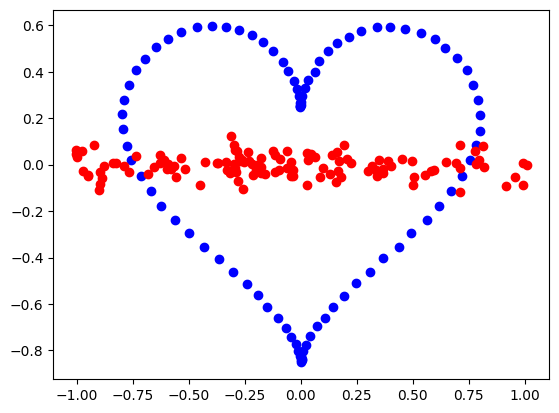

In [5]:
plt.scatter(X_4[0,:],X_4[1,:],c='b')
plt.scatter(Y_4[0,:],Y_4[1,:],c='r')

Generate the weights $a,b$.

In [6]:
normalize = lambda a: a/np.sum(a)

a = normalize(np.random.rand(n, 1))
b = normalize(np.random.rand(m, 1))

Helper function for display of clouds.

In [7]:
myplot = lambda x,y,ms,col: plt.scatter(x,y, s=ms*20, edgecolors="k", c=col, linewidths=2)

In [8]:
def plot_points(X, Y, a, b, x=None, y=None, label_density=None, title=None):
    plt.figure(figsize=(8, 6))
    plt.axis("off")

    # Plot points for group X with larger size
    for i in range(len(a)):
        plt.scatter(X[0, i], X[1, i], s=a[i] * len(a) * 50, color='deepskyblue', alpha=0.7)  # Increased size factor

    # Plot points for group Y with larger size
    for j in range(len(b)):

        plt.scatter(Y[0, j], Y[1, j], s=b[j] * len(b) * 50, color='tomato', alpha=0.7)  # Increased size factor

    # Calculate the limits for the plot
    all_x = np.concatenate([X[0, :], Y[0, :]])
    all_y = np.concatenate([X[1, :], Y[1, :]])
    x_min, x_max = all_x.min() - 0.1 * abs(np.ptp(all_x)), all_x.max() + 0.1 * abs(np.ptp(all_x))
    y_min, y_max = all_y.min() - 0.1 * abs(np.ptp(all_y)), all_y.max() + 0.1 * abs(np.ptp(all_y))

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Add legends and labels
    plt.scatter([], [], s=200, color='deepskyblue', label='Group X')  # Larger legend points
    plt.scatter([], [], s=200, color='tomato', label='Group Y')  # Larger legend points
    if x is not None:
        plt.scatter(x, y, s=200, color='limegreen', label=label_density)  # Larger density points

    # Improve legend style and positioning
    plt.legend(loc='upper right', fontsize=12, frameon=False, markerscale=1.5)

    # Title styling
    plt.title(title, fontsize=16, fontweight='bold', family='serif')

    # Show plot
    plt.show()

Display the point clouds.
The size of each dot is proportional to its probability density weight.

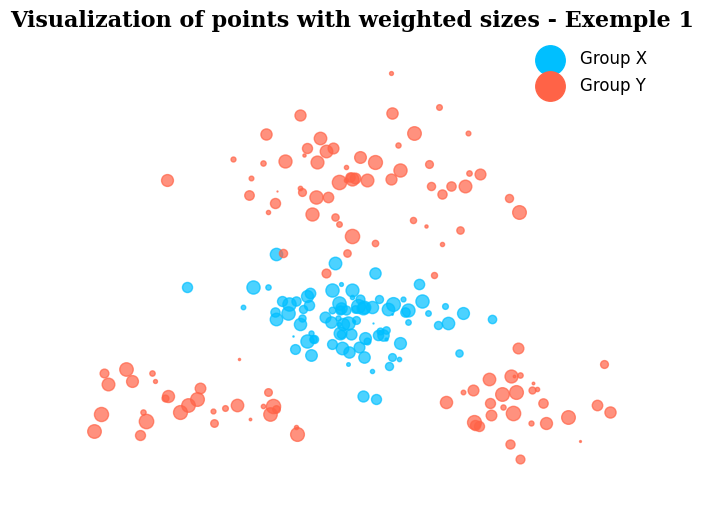

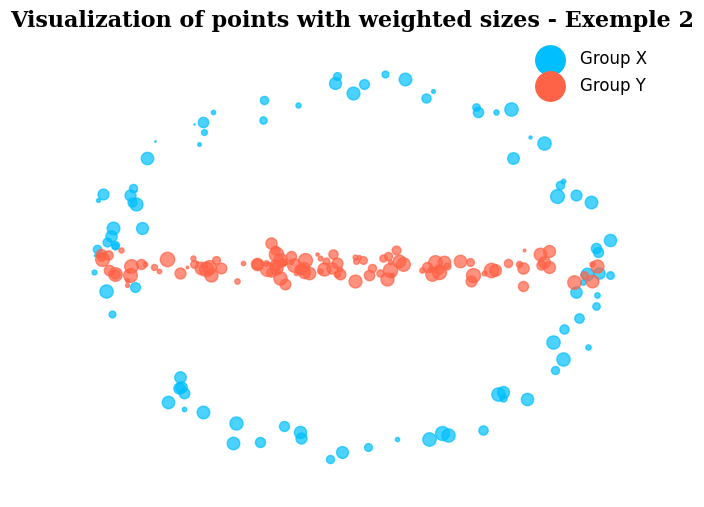

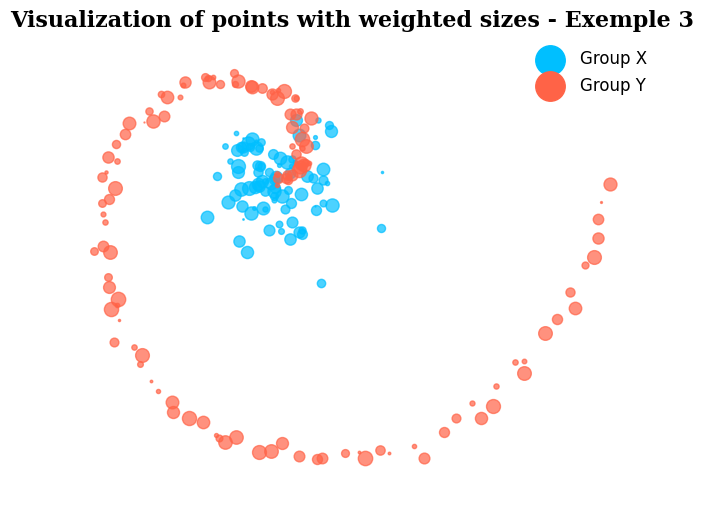

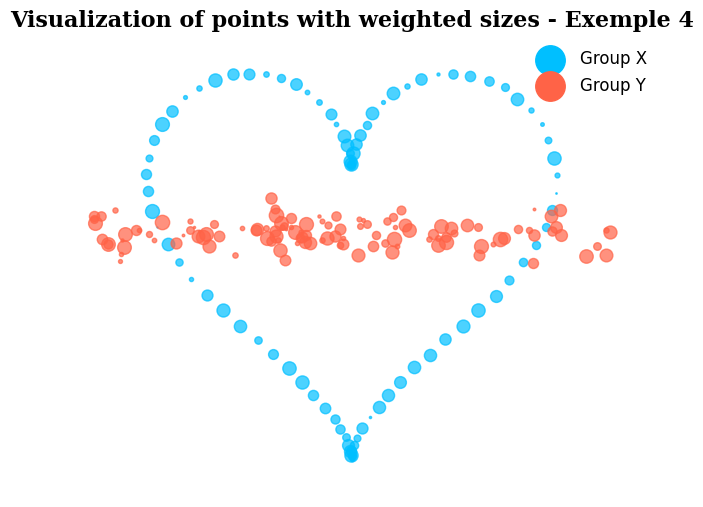

In [9]:
plot_points(X_1, Y_1, a, b, title = "Visualization of points with weighted sizes - Exemple 1")
plot_points(X_2, Y_2, a, b, title = "Visualization of points with weighted sizes - Exemple 2")
plot_points(X_3, Y_3, a, b, title = "Visualization of points with weighted sizes - Exemple 3")
plot_points(X_4, Y_4, a, b, title = "Visualization of points with weighted sizes - Exemple 4")

Compute the cost matrix $C_{i,j} := \mid \mid x_i-x_j\mid\mid^2$.

In [10]:
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)
C_1 = distmat(X_1,Y_1)
C_2 = distmat(X_2,Y_2)
C_3 = distmat(X_3,Y_3)
C_4 = distmat(X_4,Y_4)

Define the optimiztion variable $P$.

In [11]:
P_1 = cp.Variable((n,m))
P_2 = cp.Variable((n,m))
P_3 = cp.Variable((n,m))
P_4 = cp.Variable((n,m))

Define the set of discrete couplings between $\al$ and $\be$
$$ U(a,b) := \enscond{ P \in \RR_+^{n \times m} }{
     \forall i, \sum_j P_{i,j} = a_i, \:
     \forall j, \sum_i P_{i,j} = b_j }. $$

In [12]:
u = np.ones((m,1))
v = np.ones((n,1))
U_1 = [0 <= P_1, cp.matmul(P_1,u)==a, cp.matmul(P_1.T,v)==b]
U_2 = [0 <= P_2, cp.matmul(P_2,u)==a, cp.matmul(P_2.T,v)==b]
U_3 = [0 <= P_3, cp.matmul(P_3,u)==a, cp.matmul(P_3.T,v)==b]
U_4 = [0 <= P_4, cp.matmul(P_4,u)==a, cp.matmul(P_4.T,v)==b]

The Kantorovitch formulation of the optimal transport reads
$$ P^\star \in \uargmin{P \in U(a,b)} \sum_{i,j} P_{i,j} C_{i,j}.  $$
Solve it using CVXPY

In [13]:
objective = cp.Minimize(cp.sum(cp.multiply(P_1,C_1)) )
prob = cp.Problem(objective, U_1)
result_1 = prob.solve()

objective = cp.Minimize(cp.sum(cp.multiply(P_2,C_2)) )
prob = cp.Problem(objective, U_2)
result_2 = prob.solve()

objective = cp.Minimize(cp.sum(cp.multiply(P_3,C_3)) )
prob = cp.Problem(objective, U_3)
result_3 = prob.solve()

objective = cp.Minimize(cp.sum(cp.multiply(P_4,C_4)) )
prob = cp.Problem(objective, U_4)
result_4 = prob.solve()

An optimal coupling $P^\star$ can be shown to be a sparse matrix
with less than $n+m-1$ non zero entries. An entry $P_{i,j}^\star \neq 0$
should be understood as a link between $x_{i}$
and $y_{j}$ where an amount of mass equal to $P_{i,j}^\star$ is transfered.

Check that the number of non-zero entries in $P^\star$ is $n+m-1$. Beware that we are using an interior point method here, so that entries of $P^\star$ are nevery exactly 0.

In [14]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(P_1.value[P_1.value>1e-5]), n + m-1))

Number of non-zero: 209 (n + m-1 = 209)


Display the solution coupling.

In [15]:
def plot_solution(P):
    plt.figure(figsize=(10, 8))  # Increase figure size for better visibility
    # Display the matrix as an image
    plt.imshow(P.value, cmap='viridis', interpolation='nearest')  # Adjust alpha for transparency

    # Add colorbar with a larger label
    cbar = plt.colorbar(label='Valeurs de P')
    cbar.ax.tick_params(labelsize=14)  # Increase colorbar tick label size

    # Title and axis labels with increased font size
    plt.title("Solution au problème de Kantorovitch", fontsize=16, fontweight='bold')
    plt.xlabel('Index Y', fontsize=14)
    plt.ylabel('Index X', fontsize=14)

    # Make sure the aspect ratio is equal
    plt.gca().set_aspect('equal', adjustable='box')

    # Show the plot
    plt.show()

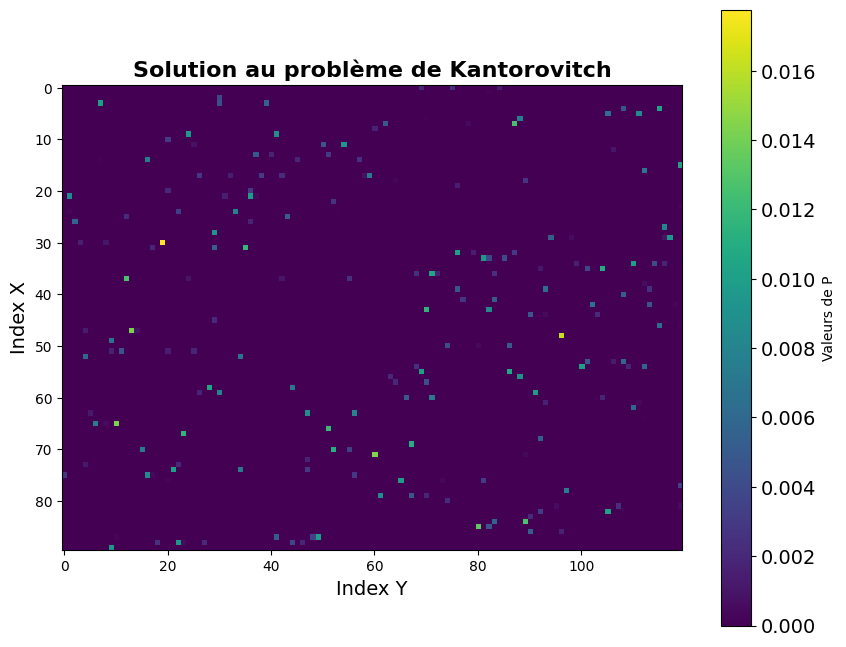

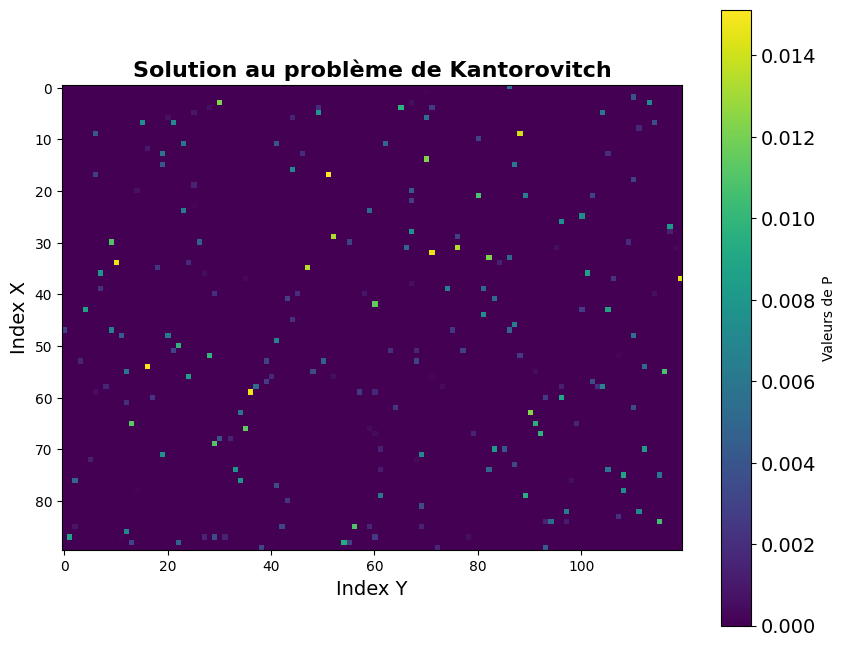

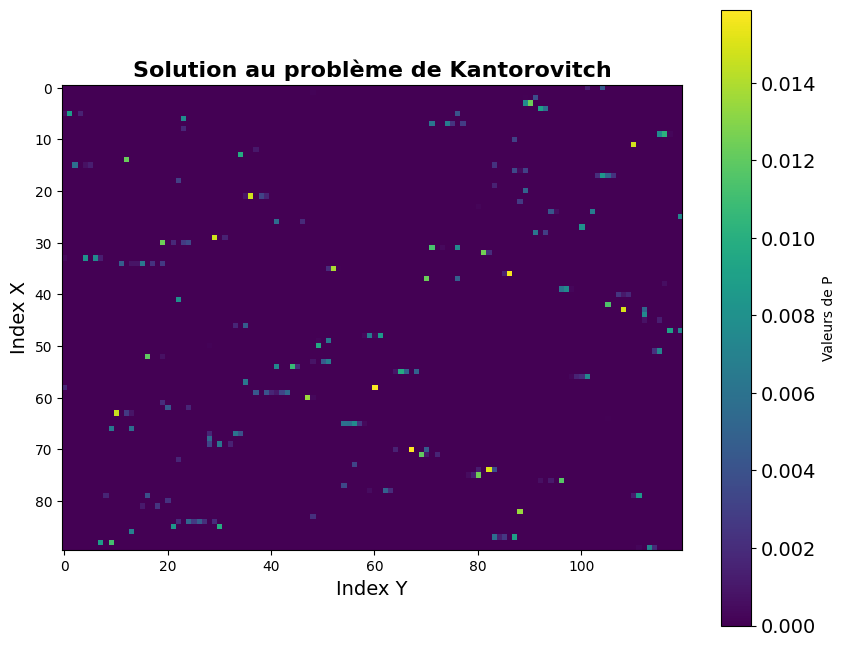

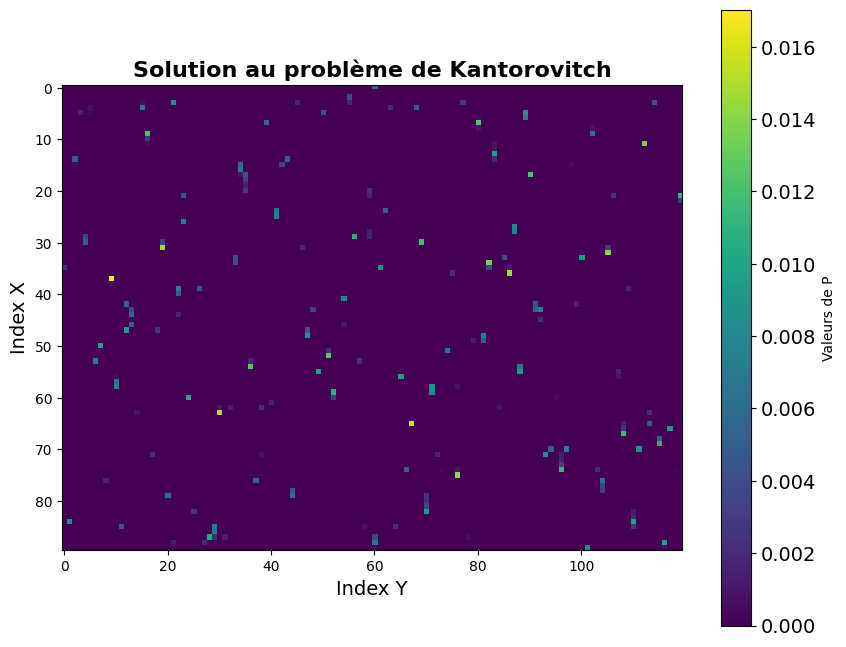

In [16]:
plot_solution(P_1)
plot_solution(P_2)
plot_solution(P_3)
plot_solution(P_4)

Display the connexion defined by the optimal coupling.

In [17]:
def plot_matching(X, Y, P):
    I, J = np.nonzero(P.value > 1e-5)

    plt.figure(figsize=(10, 7))
    plt.axis('off')

    for k in range(len(I)):
        # Plot lines between corresponding points
        plt.plot(np.hstack((X[0, I[k]], Y[0, J[k]])),
                 np.hstack(([X[1, I[k]], Y[1, J[k]]])), 'k', lw=2)

    # Plot the points of X and Y with larger sizes
    for i in range(X.shape[1]):
        plt.scatter(X[0, i], X[1, i], s=150, c='deepskyblue', alpha=0.8)  # Larger blue points for X
    for j in range(Y.shape[1]):
        plt.scatter(Y[0, j], Y[1, j], s=150,c='tomato', alpha=0.8)  # Larger red points for Y

    # Adjust limits with some padding
    all_x = np.concatenate([X[0, :], Y[0, :]])
    all_y = np.concatenate([X[1, :], Y[1, :]])
    x_min, x_max = all_x.min() - 0.1 * abs(np.ptp(all_x)), all_x.max() + 0.1 * abs(np.ptp(all_x))
    y_min, y_max = all_y.min() - 0.1 * abs(np.ptp(all_y)), all_y.max() + 0.1 * abs(np.ptp(all_y))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.title("Optimal Connections Between Points X and Y", fontsize=16, fontweight='bold')
    plt.xlabel("Coordonnée X", fontsize=12)
    plt.ylabel("Coordonnée Y", fontsize=12)
    plt.show()

In [18]:
def plot_matching_multiples(data_list, num_cols=2):
    """
    Plot multiple side-by-side graphs representing optimal matching between X and Y point sets.

    Parameters:
    -----------
    data_list : list of tuples
        List containing triplets (X, Y, P) for each plot.
        - X : ndarray (2, n) - Starting points.
        - Y : ndarray (2, m) - Ending points.
        - P : ndarray (n, m) - Weight matrix indicating optimal connections.
    num_cols : int
        Number of columns of subplots to display (default: 2).
    """
    num_plots = len(data_list)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))  # Larger figure size
    axes = np.array(axes).reshape(-1)  # Flatten for easy access

    for idx, (X, Y, P) in enumerate(data_list):
        ax = axes[idx]
        ax.axis('off')

        I, J = np.nonzero(P.value > 1e-5)
        for k in range(len(I)):
            # Plot lines between corresponding points with increased line width
            ax.plot(np.hstack((X[0, I[k]], Y[0, J[k]])),
                    np.hstack((X[1, I[k]], Y[1, J[k]])), 'k-', lw=2)  # Increased line width

        # Plot the points of X and Y with larger size and distinct colors
        a = np.linspace(1, 10, X.shape[1])  # Size scaling factor for points in X
        b = np.linspace(1, 10, Y.shape[1])  # Size scaling factor for points in Y
        for i in range(X.shape[1]):
            ax.scatter(X[0, i], X[1, i], s=a[i] * 50, c='deepskyblue', alpha=0.8)  # Larger points for X
        for j in range(Y.shape[1]):
            ax.scatter(Y[0, j], Y[1, j], s=b[j] * 50, c='tomato', alpha=0.8)  # Larger points for Y

        # Adjust the limits with some padding
        all_x = np.concatenate([X[0, :], Y[0, :]])
        all_y = np.concatenate([X[1, :], Y[1, :]])
        x_min, x_max = all_x.min() - 0.1 * abs(np.ptp(all_x)), all_x.max() + 0.1 * abs(np.ptp(all_x))
        y_min, y_max = all_y.min() - 0.1 * abs(np.ptp(all_y)), all_y.max() + 0.1 * abs(np.ptp(all_y))
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        ax.set_title(f"Optimal Mapping of Point Clouds - Example {idx + 1}", fontsize=16, fontweight='bold')

    # Remove unused axes
    for ax in axes[num_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

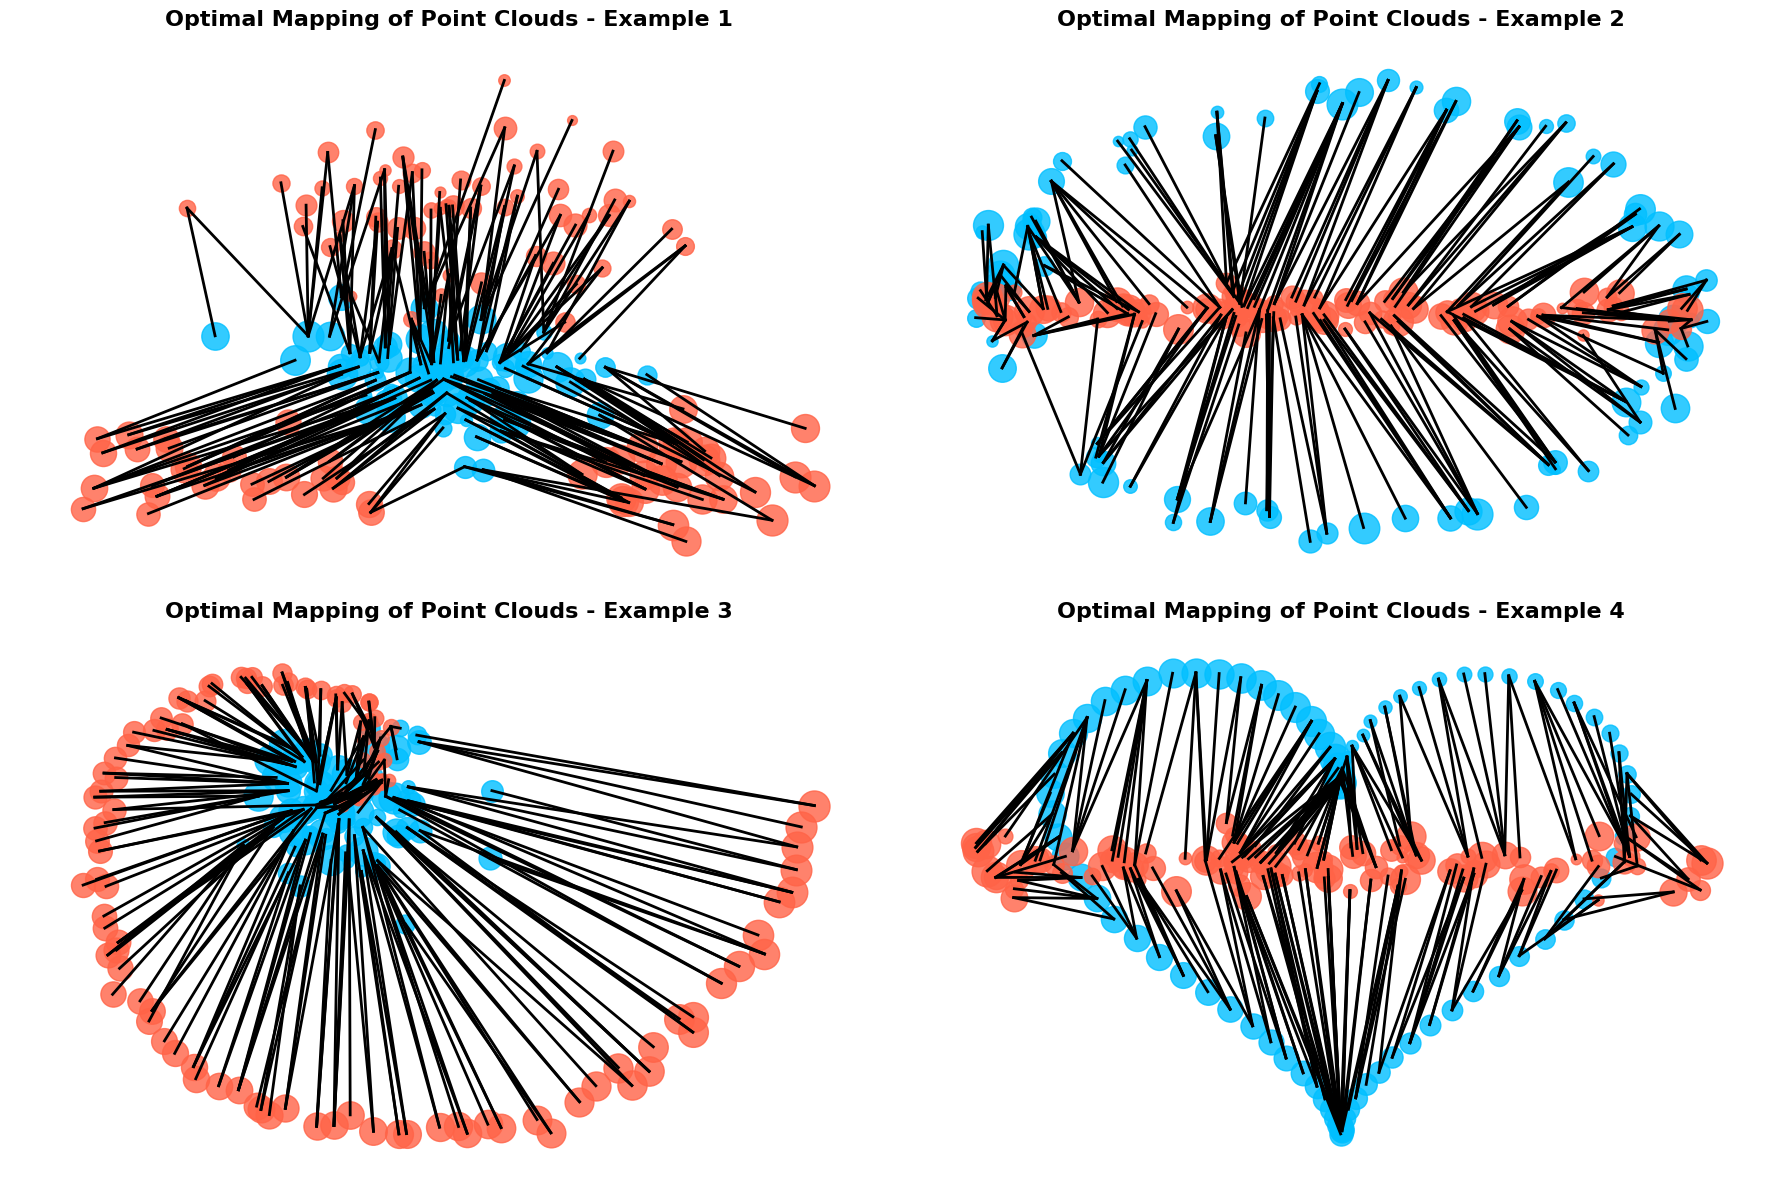

In [19]:
plot_matching_multiples([(X_1, Y_1, P_1), (X_2, Y_2, P_2), (X_3, Y_3, P_3), (X_4, Y_4, P_4)], num_cols=2)

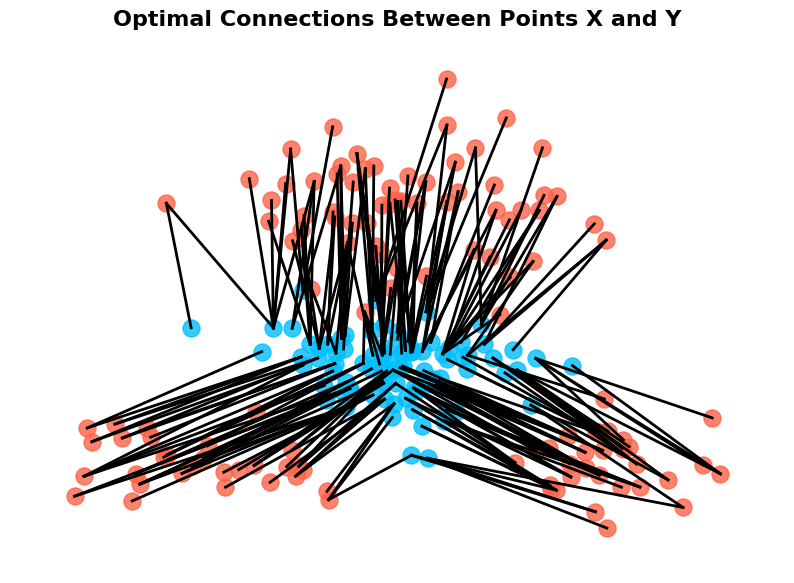

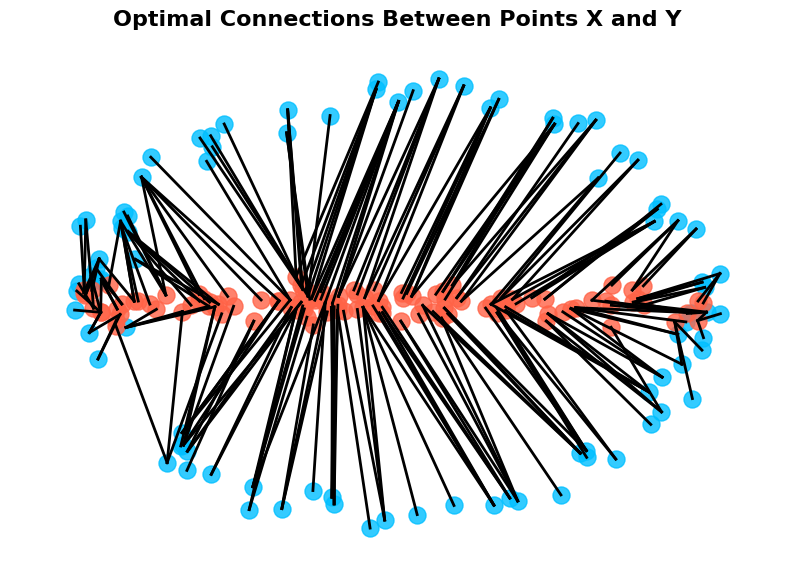

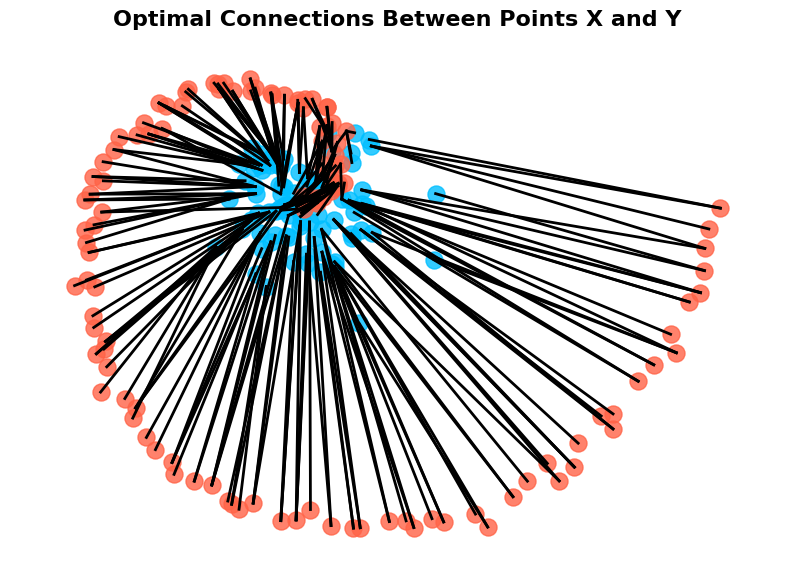

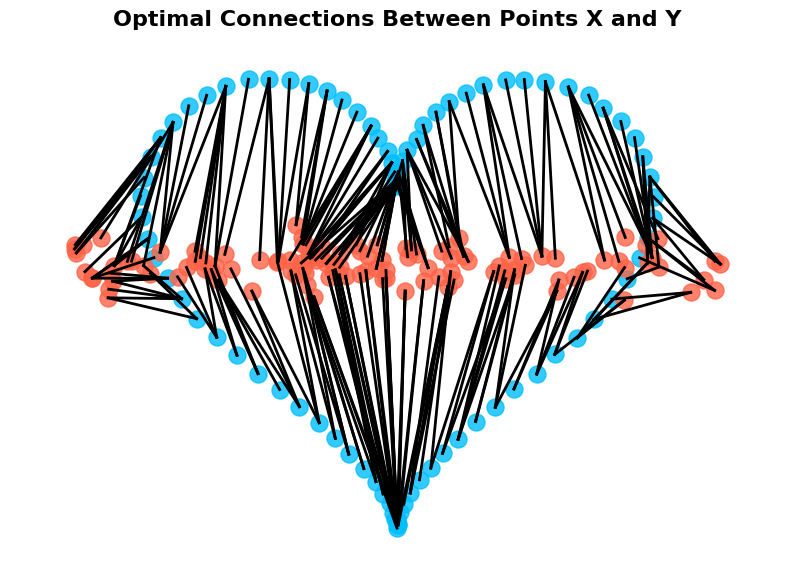

In [20]:
plot_matching(X_1, Y_1, P_1)
plot_matching(X_2, Y_2, P_2)
plot_matching(X_3, Y_3, P_3)
plot_matching(X_4, Y_4, P_4)

Displacement Interpolation
--------------------------
For any $t \in [0,1]$, one can define a distribution $\mu_t$ such
that $t \mapsto \mu_t$ defines a geodesic for the Wasserstein metric.


Since the $W_2$ distance is a geodesic distance, this geodesic path solves the
following variational problem

$$ \mu_t = \uargmin{\mu} (1-t)W_2(\al,\mu)^2 + t W_2(\be,\mu)^2. $$
This can be understood as a generalization of the usual Euclidean
barycenter to barycenter of distribution. Indeed, in the case that
$\al = \de_{x}$ and $\be=\de_y$, one has $\mu_t=\de_{x_t}$ where $ x_t =
(1-t)x+t y $.


Once the optimal coupling $P^\star$ has been computed, the
interpolated distribution is obtained as

$$ \mu_t = \sum_{i,j} P^\star_{i,j} \de_{(1-t)x_{i} + t y_{j}}. $$

Find the $i,j$ with non-zero $P_{i,j}^\star$.

In [21]:
I_1,J_1 = np.nonzero(P_1.value>1e-5)
Pij_1 = P_1.value[I_1,J_1]
I_2,J_2 = np.nonzero(P_2.value>1e-5)
Pij_2 = P_2.value[I_2,J_2]
I_3,J_3 = np.nonzero(P_3.value>1e-5)
Pij_3 = P_3.value[I_3,J_3]
I_4,J_4 = np.nonzero(P_4.value>1e-5)
Pij_4 = P_4.value[I_4,J_4]

Display the evolution of $\mu_t$ for a varying value of $t \in [0,1]$.

In [22]:
def plot_interpolation(X, Y, I, J, Pij):
    plt.figure(figsize=(12, 6))
    tlist = np.linspace(0, 1, 6)

    for i in range(len(tlist)):
        t = tlist[i]
        Xt = (1 - t) * X[:, I] + t * Y[:, J]
        plt.subplot(2, 3, i + 1)
        plt.axis("off")

        for j in range(len(Pij)):
            plt.scatter(Xt[0, j], Xt[1, j], s=Pij[j] * len(Pij) * 150, c=[t, 0, 1 - t], alpha=0.8)  # Adjust size and color

        plt.title(f"t = {t:.1f}", fontsize=14)

        # Adjust the axis limits
        all_x = np.concatenate([X[0, :], Y[0, :]])
        all_y = np.concatenate([X[1, :], Y[1, :]])
        x_min, x_max = all_x.min() - 0.1 * abs(np.ptp(all_x)), all_x.max() + 0.1 * abs(np.ptp(all_x))
        y_min, y_max = all_y.min() - 0.1 * abs(np.ptp(all_y)), all_y.max() + 0.1 * abs(np.ptp(all_y))
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()


In [23]:
def plot_interpolation_multiples(data_list, num_cols=2):
    """
    Trace plusieurs ensembles d'interpolations côte à côte.

    Parameters:
    -----------
    data_list : list of tuples
        Liste contenant les quadruplets (X, Y, I, J, Pij) pour chaque ensemble d'interpolations.
        - X : ndarray (2, n) - Coordonnées des points de départ.
        - Y : ndarray (2, m) - Coordonnées des points d'arrivée.
        - I : ndarray (k,) - Indices des points correspondants dans X.
        - J : ndarray (k,) - Indices des points correspondants dans Y.
        - Pij : ndarray (k,) - Poids des correspondances entre les points X et Y.
    num_cols : int
        Nombre de colonnes de sous-graphiques à afficher (par défaut : 2).
    """
    num_plots = len(data_list)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculer le nombre de lignes nécessaires

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = np.array(axes).reshape(-1)  # Aplatir pour un accès simple

    for idx, (X, Y, I, J, Pij) in enumerate(data_list):
        ax = axes[idx]
        tlist = np.linspace(0, 1, 6)  # Points temporels pour l'interpolation

        for i, t in enumerate(tlist):
            Xt = (1 - t) * X[:, I] + t * Y[:, J]  # Interpolation linéaire
            for j in range(len(Pij)):
                ax.scatter(Xt[0, j], Xt[1, j], s=Pij[j] * len(Pij) * 150, c=[[t, 0, 1 - t]], alpha=0.8)  # Increase size, add transparency

        # Ajuster les limites
        all_x = np.concatenate([X[0, :], Y[0, :]])
        all_y = np.concatenate([X[1, :], Y[1, :]])
        x_min, x_max = all_x.min() - 0.1 * abs(np.ptp(all_x)), all_x.max() + 0.1 * abs(np.ptp(all_x))
        y_min, y_max = all_y.min() - 0.1 * abs(np.ptp(all_y)), all_y.max() + 0.1 * abs(np.ptp(all_y))
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.axis("off")
        ax.set_title(f"Displacement Interpolation with time - Example {idx + 1}", fontsize=14)

    # Supprimer les axes inutilisés
    for ax in axes[num_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


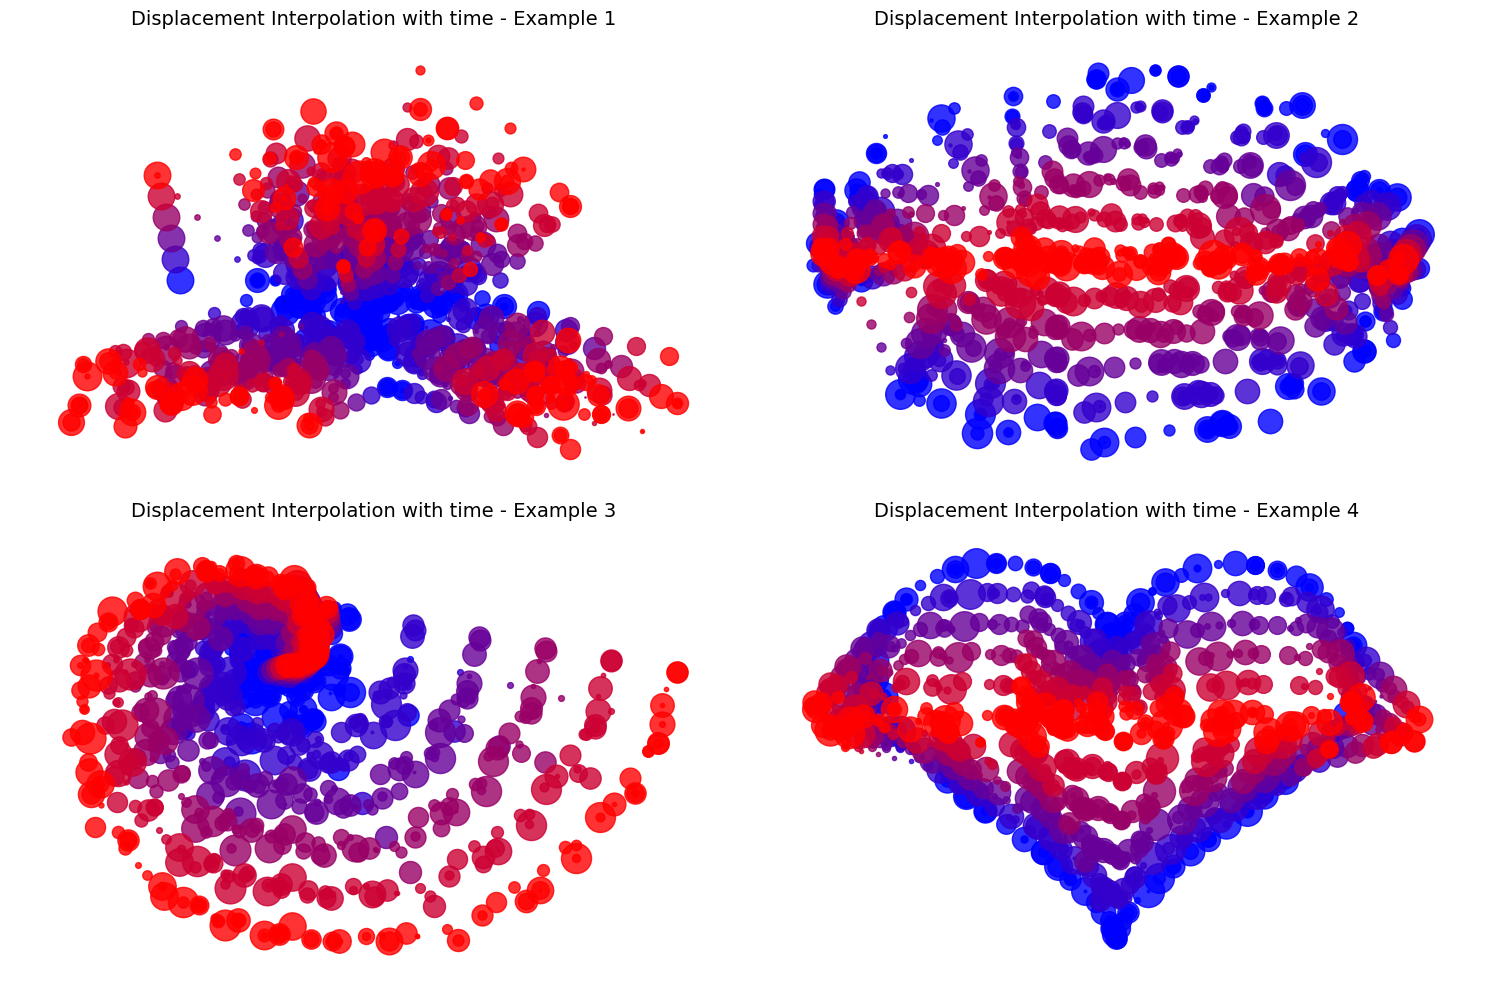

In [24]:
plot_interpolation_multiples([(X_1, Y_1, I_1, J_1, Pij_1), (X_2, Y_2, I_2, J_2, Pij_2), (X_3, Y_3, I_3, J_3, Pij_3), (X_4, Y_4, I_4, J_4, Pij_4)], num_cols=2)

/var/folders/tf/1s1659hs28jc69nxhytmsqz00000gn/T/ipykernel_98709/4114653964.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(Xt[0, j], Xt[1, j], s=Pij[j] * len(Pij) * 150, c=[t, 0, 1 - t], alpha=0.8)  # Adjust size and color


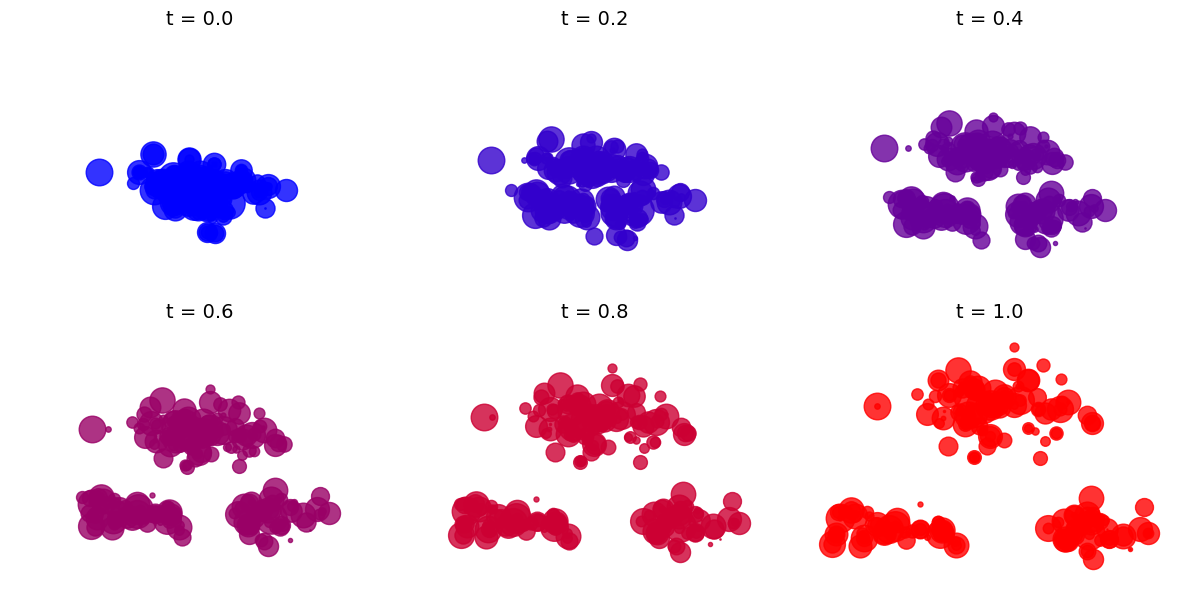

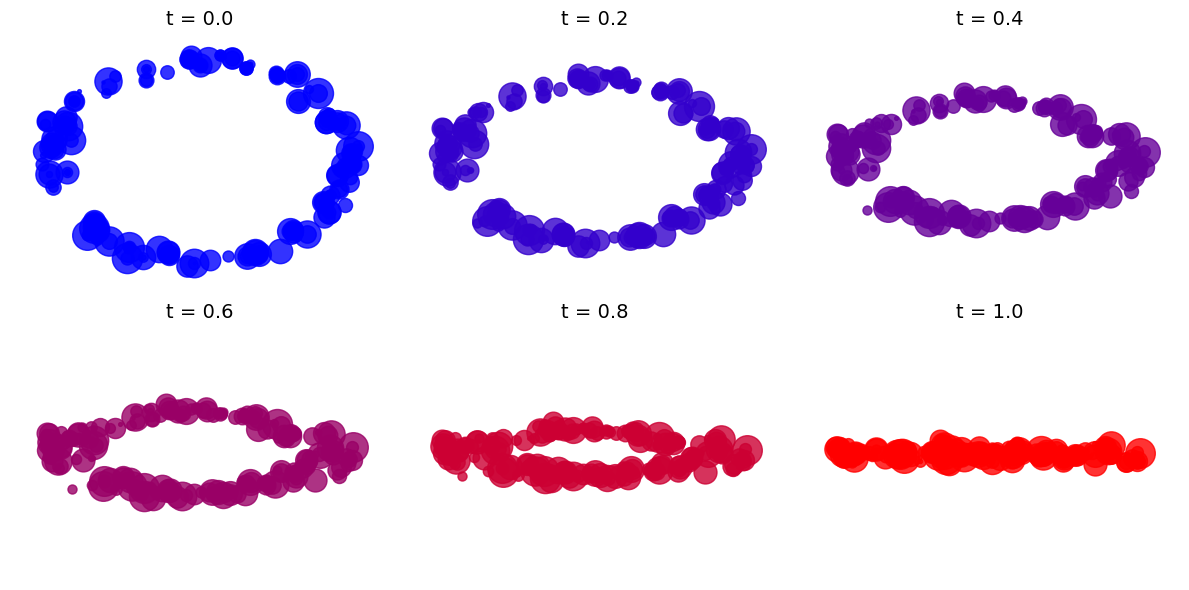

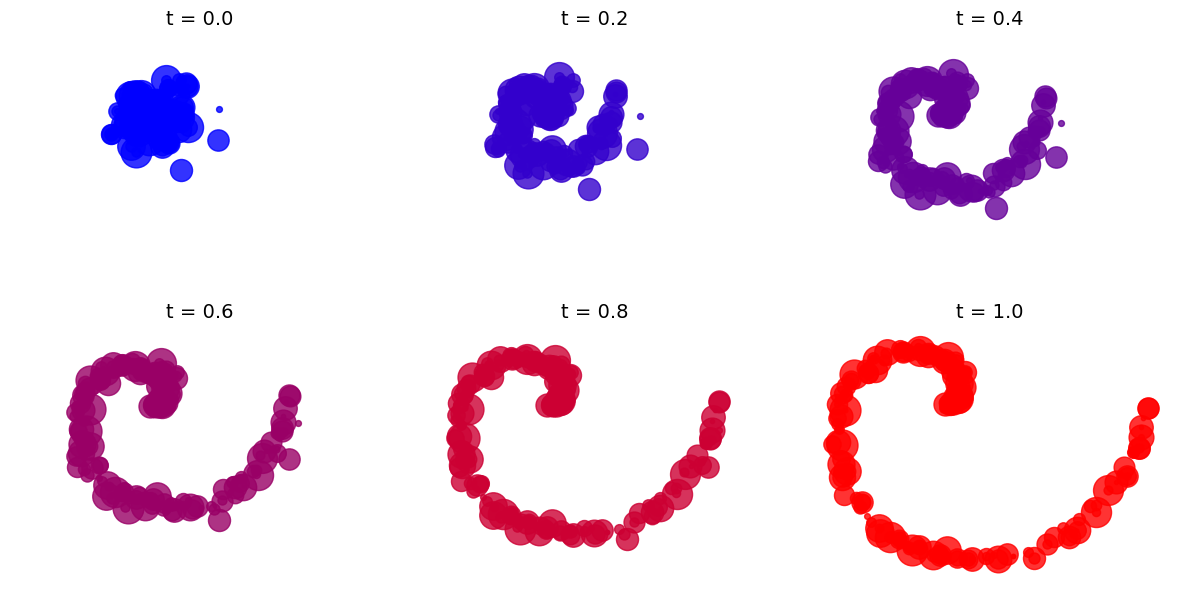

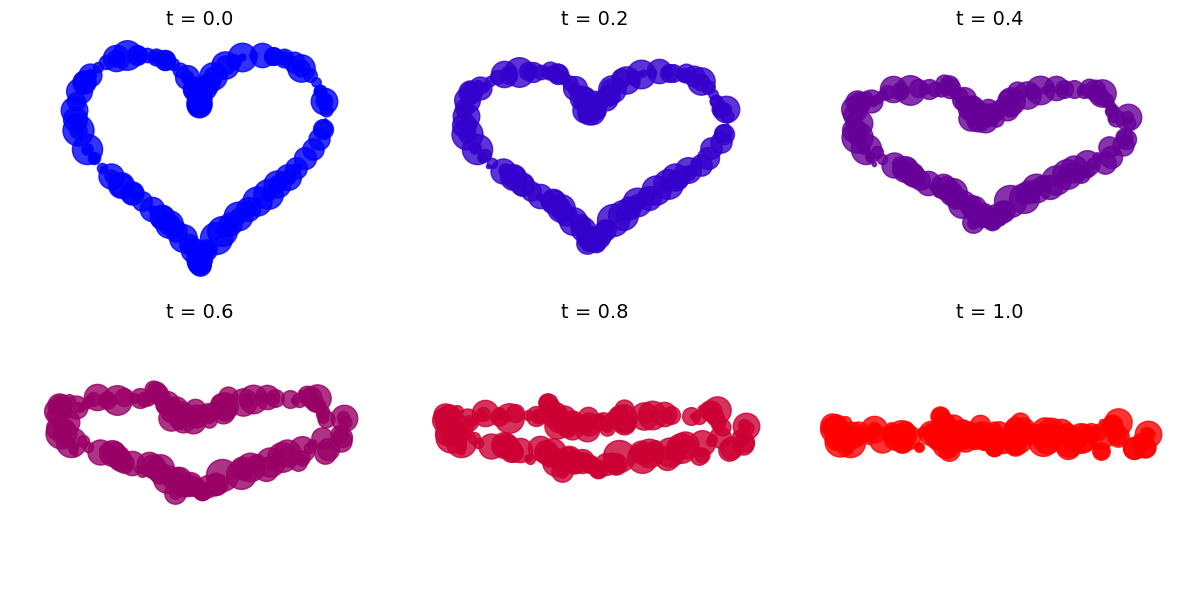

In [25]:
plot_interpolation(X_1, Y_1, I_1, J_1, Pij_1)
plot_interpolation(X_2, Y_2, I_2, J_2, Pij_2)
plot_interpolation(X_3, Y_3, I_3, J_3, Pij_3)
plot_interpolation(X_4, Y_4, I_4, J_4, Pij_4)

Optimal Assignement
-------------------
In the case where $n=m$ and the weights are uniform $a_{i}=1/n, b_{j}=1/n$, one can show that there is at least one optimal transport coupling which is actually a
permutation matrix. This properties comes from the fact that
the extremal point of the polytope $U(1,1)$ are permutation matrices.


This means that there exists an optimal permutation $\si^\star \in \Sigma_n$ such
that
$$ P^\star_{i,j} = \choice{
      1 \qifq j=\si^\star(i), \\
      0 \quad\text{otherwise}.
  } $$
  
where $\Si_n$ is the set of permutation (bijections) of
$\{1,\ldots,n\}$.


This permutation thus solves the so-called optimal assignement problem
$$ \si^\star \in \uargmin{\si \in \Sigma_n}
      \sum_{i} C_{i,\si(j)}. $$

Use the same number of points.

In [36]:
n = 40
m = n

Compute points clouds.

In [37]:
X_1 = np.random.randn(2,n)*.3
Y_1 = np.hstack((gauss(int(m/2),.5,[0,1.6]),np.hstack((gauss(int(m/4),.3,[-1,-1]),gauss(int(m/4),.3,[1,-1])))))

theta = np.random.rand(n)*2*np.pi
X_2 = [np.cos(theta), np.sin(theta)] + np.random.randn(2,n)*.05 #Cercle bruité
Y_2 = [np.random.rand(m)*2-1, np.zeros(m)] + np.random.randn(2,m)*.05

t = np.linspace(0, 2 * np.pi, m)
r = a_ * t
X_3 = np.random.randn(2,n)*.3
Y_3 = np.stack((r * np.cos(t), r * np.sin(t)), axis=1).T + (np.random.randn(2, m)*sigma) #Spirale bruitée

# Heart Curve (X_4)
theta = np.linspace(0, 2 * np.pi, n)
x_heart = 16 * (np.sin(theta) ** 3)
y_heart = 13 * np.cos(theta) - 5 * np.cos(2 * theta) - 2 * np.cos(3 * theta) - np.cos(4 * theta)

# Add noise to heart curve points
x_noisy = x_heart + np.random.randn(n) * sigma
y_noisy = y_heart + np.random.randn(n) * sigma
X_4 =  0.05* np.vstack([x_noisy, y_noisy])  # Shape: (2, n_points)

# Random Labels (Y_4)
Y_4_x = np.random.uniform(np.min(x_heart), np.max(x_heart), m)
Y_4_y = np.random.uniform(np.min(y_heart), np.max(y_heart), m)
Y_4 = Y_2


Constant distributions.

In [38]:
a = np.ones([n,1])/n
b = a

Compute the weight matrix $ (C_{i,j})_{i,j}. $

In [39]:
C_1 = distmat(X_1,Y_1)
C_2 = distmat(X_2,Y_2)
C_3 = distmat(X_3,Y_3)
C_4 = distmat(X_4,Y_4)

Display the coulds.

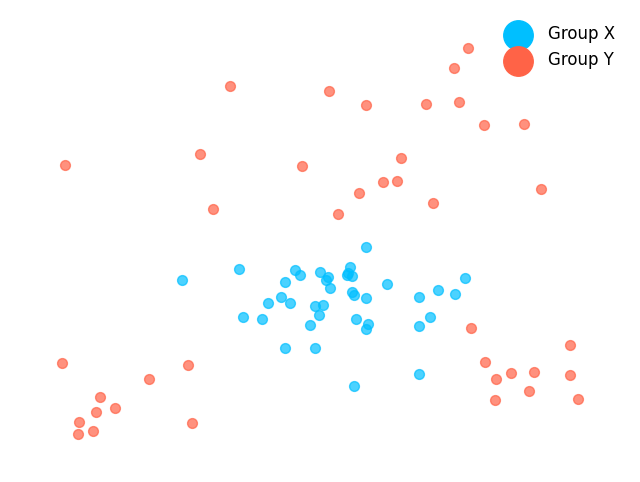

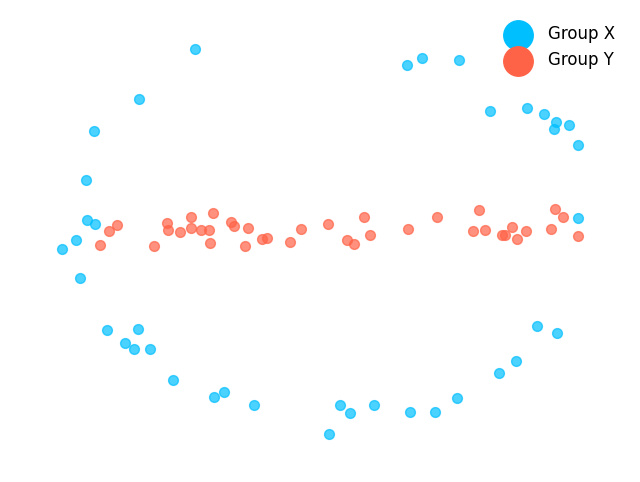

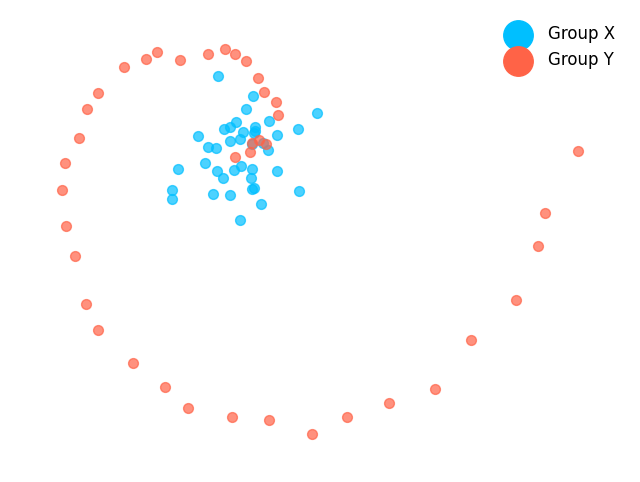

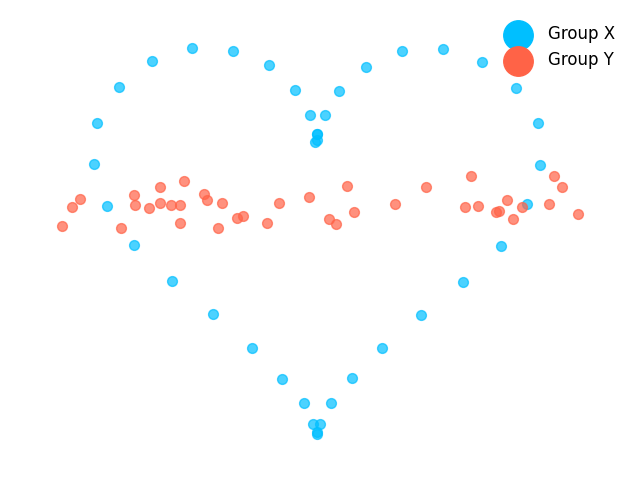

In [40]:
plot_points(X_1, Y_1, a, b)
plot_points(X_2, Y_2, a, b)
plot_points(X_3, Y_3, a, b)
plot_points(X_4, Y_4, a, b)

Solve the optimal transport.

In [41]:
P_1 = cp.Variable((n,m))
P_2 = cp.Variable((n,m))
P_3 = cp.Variable((n,m))
P_4 = cp.Variable((n,m))
u = np.ones((m,1))
v = np.ones((n,1))
U_1 = [0 <= P_1, cp.matmul(P_1,u)==a, cp.matmul(P_1.T,v)==b]
objective = cp.Minimize( cp.sum(cp.multiply(P_1,C_1)) )
prob = cp.Problem(objective, U_1)
result_1 = prob.solve()

U_2 = [0 <= P_2, cp.matmul(P_2,u)==a, cp.matmul(P_2.T,v)==b]
objective = cp.Minimize( cp.sum(cp.multiply(P_2,C_2)) )
prob = cp.Problem(objective, U_2)
result_2 = prob.solve()

U_3 = [0 <= P_3, cp.matmul(P_3,u)==a, cp.matmul(P_3.T,v)==b]
objective = cp.Minimize( cp.sum(cp.multiply(P_3,C_3)) )
prob = cp.Problem(objective, U_3)
result_3 = prob.solve()

U_4 = [0 <= P_4, cp.matmul(P_4,u)==a, cp.matmul(P_4.T,v)==b]
objective = cp.Minimize( cp.sum(cp.multiply(P_4,C_4)) )
prob = cp.Problem(objective, U_4)
result_4 = prob.solve()

Show that $P$ is a binary permutation matrix.

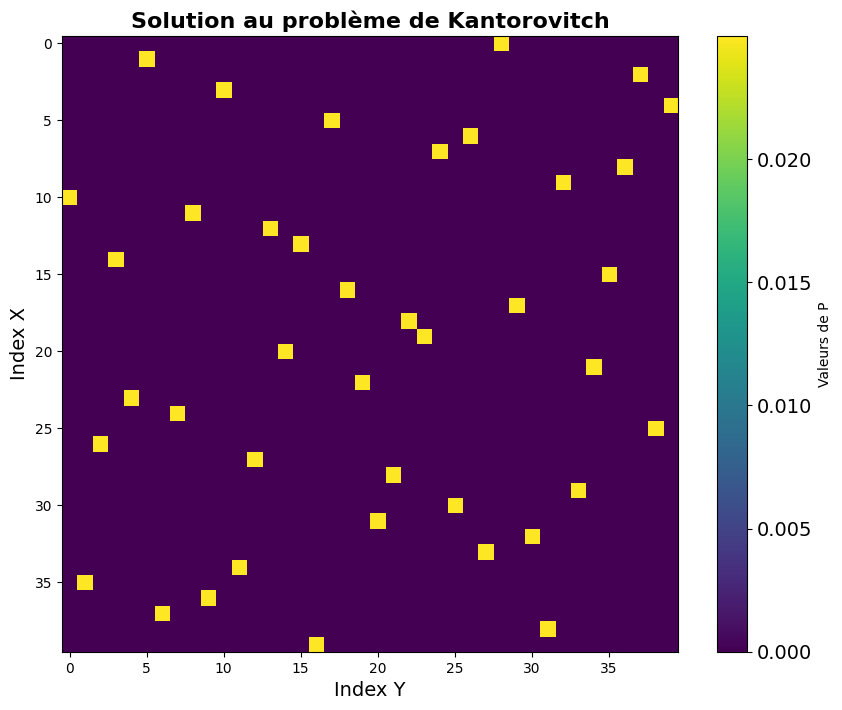

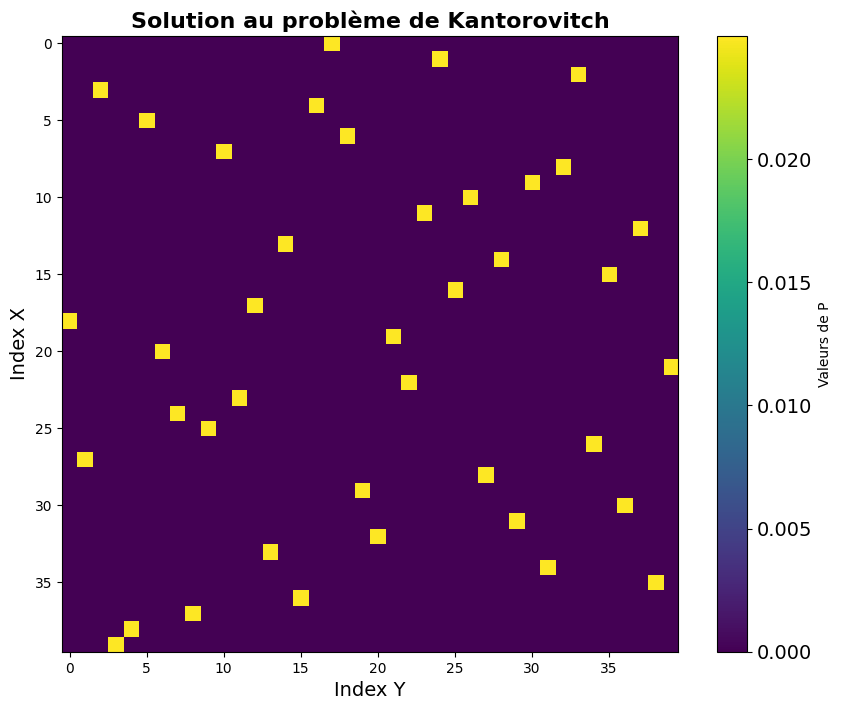

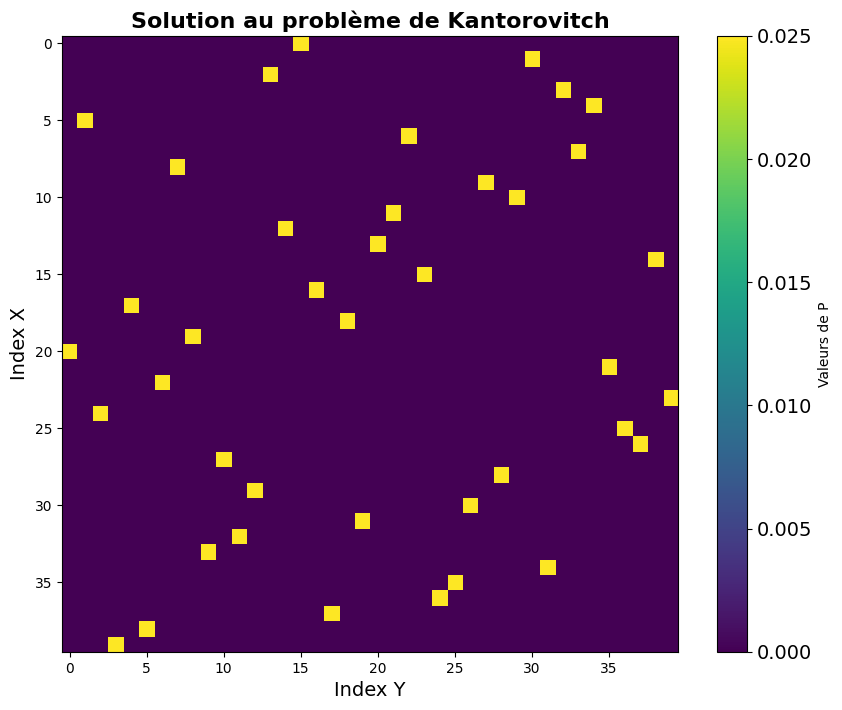

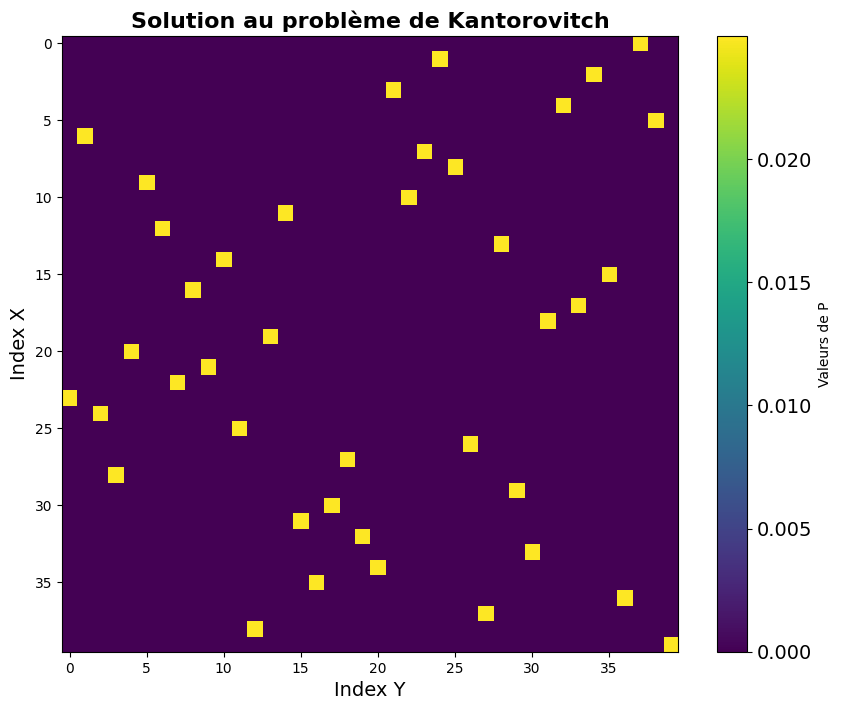

In [42]:
plot_solution(P_1)
plot_solution(P_2)
plot_solution(P_3)
plot_solution(P_4)

Display the optimal assignement.

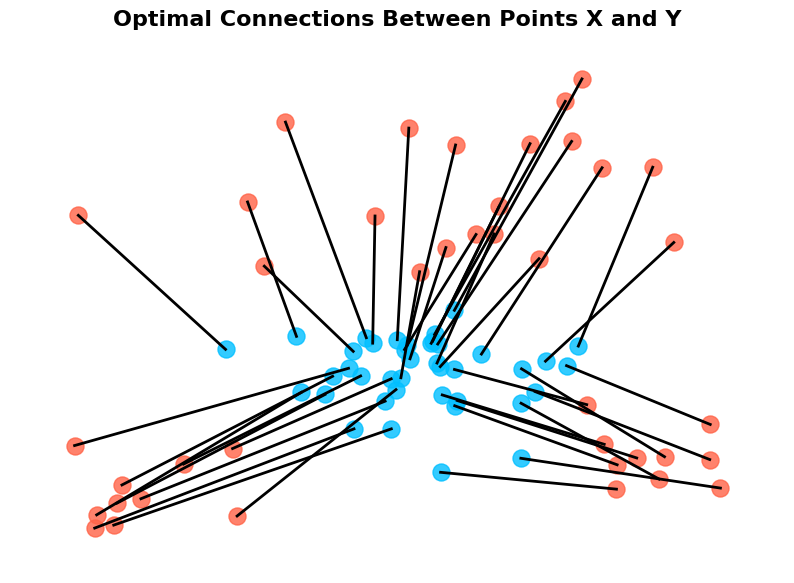

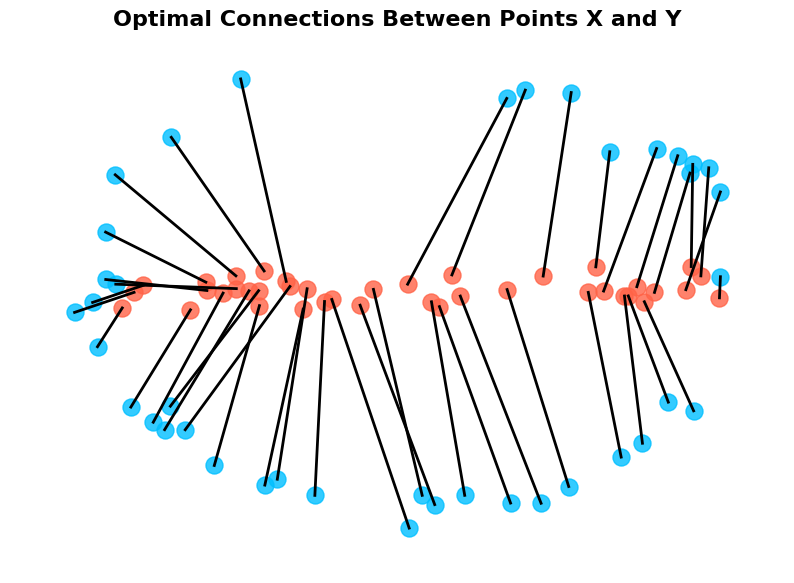

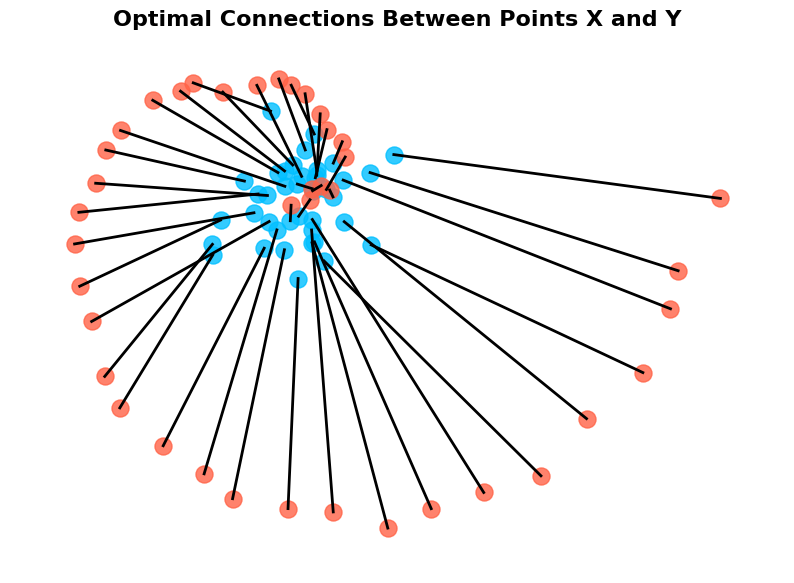

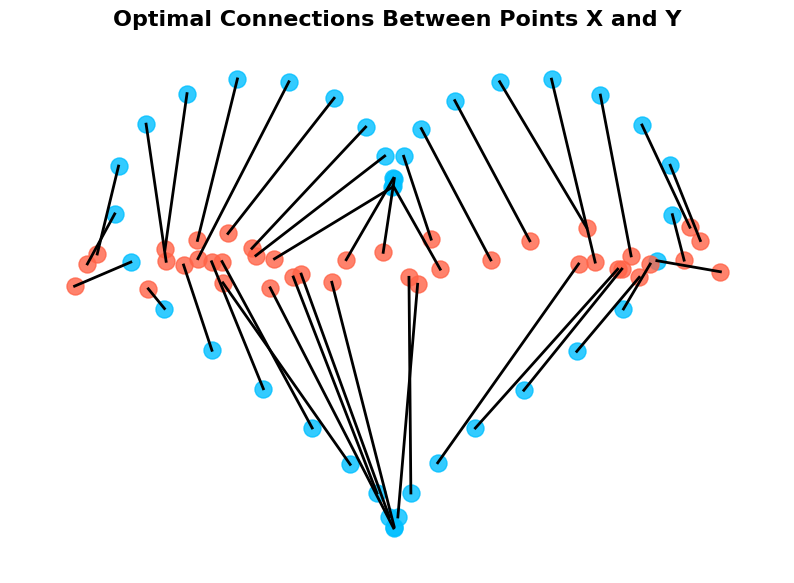

In [43]:
plot_matching(X_1, Y_1, P_1)
plot_matching(X_2, Y_2, P_2)
plot_matching(X_3, Y_3, P_3)
plot_matching(X_4, Y_4, P_4)